In [13]:
from traffic.core import Traffic
from tqdm.auto import tqdm
import numpy as np
import os

In [2]:
trajs = Traffic.from_file('data/rectangle_1//combined/combined.parquet')

In [3]:
trajs = trajs.resample(100).eval(max_workers=20)

In [4]:
X = []
for flight in tqdm(trajs):
    df = flight.data[['latitude', 'longitude', 'altitude']]
    df = df.interpolate(method='linear', limit_direction='both').ffill().bfill()
    df_as_np = df.to_numpy()
    X.append(df_as_np)

X = np.array(X)

  0%|          | 0/64023 [00:00<?, ?it/s]

In [5]:
X.shape

(64023, 100, 3)

In [6]:
indexList_X_nan = [np.any(i) for i in np.isnan(X)]
X = np.delete(X, indexList_X_nan, axis=0)
X.shape

(64023, 100, 3)

### Min Max scaling

In [8]:
lat_max = np.max(X[:,:,0])
lat_min = np.min(X[:,:,0])
lon_max = np.max(X[:,:,1])
lon_min = np.min(X[:,:,1])
alt_max = np.max(X[:,:,2])
alt_min = np.min(X[:,:,2])
print(lat_max, lat_min, lon_max, lon_min, alt_max, alt_min)

X_norm = X.copy() 
X_norm[:,:,0] = (X_norm[:,:,0] - lat_min) / (lat_max - lat_min)
X_norm[:,:,1] = (X_norm[:,:,1] - lon_min) / (lon_max - lon_min)
X_norm[:,:,2] = (X_norm[:,:,2] - alt_min) / (alt_max - alt_min)

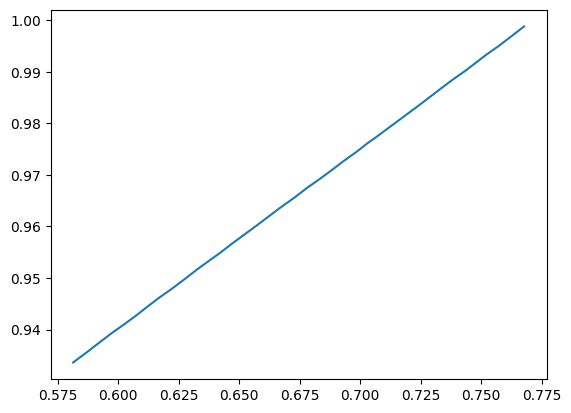

In [113]:
x=4887

lat = X_norm[x,:,0]
lon = X_norm[x,:,1]
# plot lat/lon
import matplotlib.pyplot as plt
plt.plot(lon, lat)
plt.show()

In [15]:
if not os.path.exists('data/rectangle_1/training'):
        os.makedirs('data/rectangle_1/training')

np.save('data/rectangle_1/training/X_norm', X_norm)
with open('data/rectangle_1/training/normalisation.txt', 'w') as f:
    f.write(str(lat_max) + ' ' + str(lat_min) + ' ' + str(lon_max) + ' ' + str(lon_min) + ' ' + str(alt_max) + ' ' + str(alt_min))
   

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-16 16:01:57.100987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 16:01:57.252332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 16:01:57.252356: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-16 16:01:57.840015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [55]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [56]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(100, 3))
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 100, 3)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 50, 32)       320         ['input_21[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 25, 64)       6208        ['conv1d_4[0][0]']               
                                                                                                  
 flatten_7 (Flatten)            (None, 1600)         0           ['conv1d_5[0][0]']               
                                                                                            

In [57]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(25*64, activation="relu")(latent_inputs) # 25 = 100/4 (due to strides=2 in encoder)
x = layers.Reshape((25, 64))(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 64)]              0         
                                                                 
 dense_22 (Dense)            (None, 1600)              104000    
                                                                 
 reshape_15 (Reshape)        (None, 25, 64)            0         
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 50, 64)           12352     
 Transpose)                                                      
                                                                 
 conv1d_transpose_19 (Conv1D  (None, 100, 32)          6176      
 Transpose)                                                      
                                                                 
 conv1d_transpose_20 (Conv1D  (None, 100, 3)           291 

In [58]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [78]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_norm, epochs=100, batch_size=128)

Epoch 1/100
501/501 [==============================] - 8s 14ms/step - loss: 62.7944 - reconstruction_loss: 62.8461 - kl_loss: 6.8316e-05
Epoch 2/100
501/501 [==============================] - 7s 13ms/step - loss: 62.8114 - reconstruction_loss: 62.8464 - kl_loss: 5.6794e-05
Epoch 3/100
501/501 [==============================] - 7s 13ms/step - loss: 62.8860 - reconstruction_loss: 62.8489 - kl_loss: 5.9344e-05
Epoch 4/100
501/501 [==============================] - 7s 13ms/step - loss: 62.9358 - reconstruction_loss: 62.8375 - kl_loss: 4.8553e-05
Epoch 5/100
501/501 [==============================] - 7s 13ms/step - loss: 62.8075 - reconstruction_loss: 62.8447 - kl_loss: 4.0580e-05
Epoch 6/100
501/501 [==============================] - 7s 13ms/step - loss: 62.8431 - reconstruction_loss: 62.8390 - kl_loss: 3.4080e-05
Epoch 7/100
501/501 [==============================] - 7s 13ms/step - loss: 62.9125 - reconstruction_loss: 62.8412 - kl_loss: 4.6996e-05
Epoch 8/100
501/501 [====================

KeyboardInterrupt: 

In [79]:
# function xn that returns a random number between -1 and 1
import random
def xn():
    return random.uniform(-1, 1)

z_sample = np.array([[xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(),
                      xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(),
                      xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(),
                      xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(),
                      xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(),
                      xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(), xn(),
                      xn(), xn(), xn(), xn()]])
vae.decoder.predict(z_sample)

1/1 [==============================] - 0s 37ms/step


array([[[0.6907426 , 0.549371  , 0.19463943],
        [0.6969621 , 0.55315137, 0.19721623],
        [0.69641465, 0.5558978 , 0.2002591 ],
        [0.69754356, 0.56000936, 0.20656154],
        [0.6959812 , 0.5605308 , 0.20772927],
        [0.69853127, 0.5632093 , 0.21292295],
        [0.69678175, 0.5653821 , 0.2172706 ],
        [0.6970598 , 0.5670314 , 0.22266777],
        [0.6965304 , 0.5686469 , 0.22765566],
        [0.69782305, 0.5719155 , 0.2325912 ],
        [0.6970885 , 0.5730434 , 0.23560426],
        [0.69627756, 0.57549554, 0.24117318],
        [0.6961896 , 0.57737076, 0.24446844],
        [0.6962764 , 0.58032095, 0.24922732],
        [0.6976585 , 0.58225393, 0.25289145],
        [0.6988165 , 0.5854551 , 0.2581783 ],
        [0.69919527, 0.5864115 , 0.26213562],
        [0.6986488 , 0.5917564 , 0.27093855],
        [0.69798994, 0.59200335, 0.27446032],
        [0.69835865, 0.5958397 , 0.2776271 ],
        [0.6987633 , 0.59930134, 0.28584182],
        [0.6999781 , 0.6008295 , 0

In [81]:
flight = X_norm[0]
flight

array([[0.00111813, 0.53393342, 0.66666667],
       [0.00949477, 0.53452993, 0.66666667],
       [0.02021482, 0.53508716, 0.66666667],
       [0.03298477, 0.5359337 , 0.66666667],
       [0.04262863, 0.53650522, 0.66666667],
       [0.05185318, 0.53707673, 0.66666667],
       [0.06172066, 0.53773396, 0.66666667],
       [0.07134122, 0.53829118, 0.66666667],
       [0.08078474, 0.53893413, 0.66666667],
       [0.09294438, 0.53964852, 0.66666667],
       [0.1031473 , 0.54036291, 0.66666667],
       [0.11223209, 0.54093442, 0.66666667],
       [0.122435  , 0.54150593, 0.66666667],
       [0.13236305, 0.54219174, 0.66666667],
       [0.14326013, 0.5429347 , 0.66666667],
       [0.1532534 , 0.5435848 , 0.66666667],
       [0.16246165, 0.54414202, 0.66666667],
       [0.17304427, 0.54483855, 0.66666667],
       [0.18295367, 0.5455065 , 0.66666667],
       [0.19161917, 0.54607801, 0.66666667],
       [0.20492955, 0.54692813, 0.66666667],
       [0.21342266, 0.54736391, 0.66666667],
       [0.

In [92]:
enc = vae.encoder.predict(flight.reshape(1, 100, 3))
enc[0]

1/1 [==============================] - 0s 32ms/step


array([[-5.94833749e-04,  2.18290510e-03, -7.29250780e-04,
        -3.49014212e-04, -5.53219928e-04, -1.75494724e-03,
        -5.92566910e-04, -6.97277894e-04, -1.43785484e-03,
        -2.50421977e-03,  1.68913184e-03, -6.14593155e-04,
         1.38475327e-03,  1.15330622e-03,  4.44701349e-04,
         5.68347226e-04, -8.27022945e-04,  9.56963864e-04,
         9.38942540e-04,  8.30798002e-04,  6.92930655e-04,
        -8.77820305e-04, -1.22959586e-03,  7.27375911e-04,
         1.30962243e-03, -2.51902849e-04, -2.69175565e-04,
        -1.53219653e-03, -6.46170229e-04, -2.26960168e-03,
        -7.87536497e-04,  8.32755934e-04,  7.93049170e-04,
         1.30994618e-03,  9.72002163e-04,  1.17898584e-04,
         1.07937166e-03,  7.66088255e-04,  1.69732404e-04,
         1.03906204e-03,  4.74554108e-05,  5.60283021e-04,
        -1.19557162e-03,  8.12663406e-04,  1.43915764e-03,
        -2.04384048e-03,  7.86685967e-04,  3.11117154e-04,
        -5.74607984e-04,  1.90559868e-03,  7.39016104e-0

In [93]:
vae.decoder.predict(enc[0])

1/1 [==============================] - 0s 29ms/step


array([[[0.6892302 , 0.54904354, 0.19475594],
        [0.69607234, 0.5533517 , 0.19754434],
        [0.695689  , 0.5563254 , 0.20038743],
        [0.69744194, 0.5588974 , 0.20549928],
        [0.69646275, 0.56053394, 0.20764148],
        [0.6977079 , 0.56322026, 0.21370761],
        [0.6966444 , 0.5651057 , 0.21830036],
        [0.6968043 , 0.5675191 , 0.2249658 ],
        [0.69646615, 0.56900406, 0.22786106],
        [0.69774747, 0.5719139 , 0.2325519 ],
        [0.69670725, 0.57219535, 0.23568642],
        [0.69607025, 0.5755879 , 0.24150452],
        [0.6960862 , 0.5766936 , 0.24302602],
        [0.6972692 , 0.57985264, 0.24725203],
        [0.6972171 , 0.58112186, 0.2527848 ],
        [0.6984051 , 0.5854509 , 0.25698325],
        [0.6987298 , 0.5859721 , 0.26265988],
        [0.69844806, 0.5905035 , 0.26780972],
        [0.69863653, 0.5914969 , 0.27254704],
        [0.6982881 , 0.5940336 , 0.27468854],
        [0.698382  , 0.59858173, 0.2837322 ],
        [0.7000341 , 0.59987336, 0